In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np

from generator import Generator
from discriminator import Discriminator
from dataset import SatelliteDataset
from utils import save_example
import config
from datautils import create_img_from_classes, unprocess

In [2]:
device = "cpu"

In [3]:
ds = SatelliteDataset("../../data/train")
batch_size = 1
loader = DataLoader(ds, batch_size, shuffle=True)

In [4]:
rgb_a, rgb_ab, lc_a, lc_b, binary_mask, lc_ab, masked_areas = next(iter(loader))
rgb_a, rgb_ab, lc_a, lc_b, binary_mask = rgb_a.to(device), rgb_ab.to(device), lc_a.to(device), lc_b.to(device), binary_mask.to(device)
lc_ab = lc_ab.to(device)

In [5]:
vgg_model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).to(device)
relu3_3 = torch.nn.Sequential(*vgg_model.features[:16])

Using cache found in C:\Users\hugih/.cache\torch\hub\pytorch_vision_v0.9.0


In [6]:
class StyleLoss(nn.Module):
    
    def __init__(self, relu3_3):
        super(StyleLoss, self).__init__()
        
        self.relu3_3 = relu3_3
        
    def forward(self, img1, img2):
        if len(img1.shape) == 3:
            img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))
            img2 = img2.reshape((1, img2.shape[0], img2.shape[1], img2.shape[2]))
        phi1 = self.relu3_3(img1)
        phi2 = self.relu3_3(img2)

        batch_size, c, h, w = phi1.shape
        psi1 = phi1.reshape((batch_size, c, w*h))
        psi2 = phi2.reshape((batch_size, c, w*h))

        gram1 = torch.matmul(psi1, torch.transpose(psi1, 1, 2)) / (c*h*w)
        gram2 = torch.matmul(psi2, torch.transpose(psi2, 1, 2)) / (c*h*w)
        # as described in johnson et al.
        return torch.sum(torch.norm(gram1 - gram2, p = "fro", dim=(1,2))) / batch_size

In [7]:
style_loss_fn = StyleLoss(relu3_3)
feature_loss_fn = nn.MSELoss()

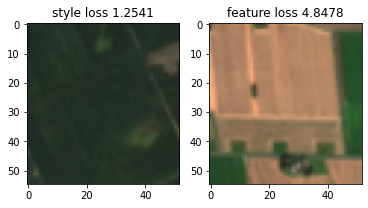

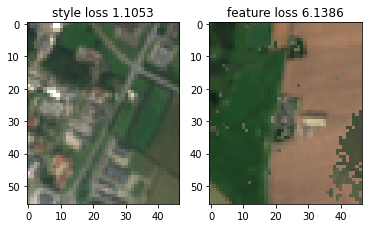

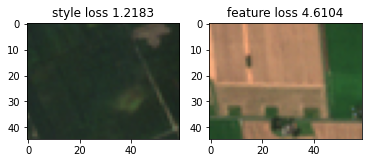

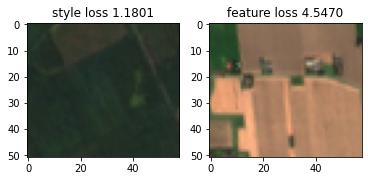

In [8]:

rgb_a_unchanged_area = rgb_a.clone()

# look individually at changed area and do a pixel loss
# Not sure what type of loss is best,
# Maybe using some kind of local discriminator would be better, like in local and global inpainting paper
for j in range(len(masked_areas[0][0])):
    for i in range(len(masked_areas)):

        r_w = masked_areas[i][0][j]
        r_h = masked_areas[i][1][j]
        mask_size_w = masked_areas[i][2][j]
        mask_size_h = masked_areas[i][3][j]

        #r_w, r_h, mask_size_w, mask_size_h = masked_area
        # maybe not use the rgb_a is the classes are the same.
      #  local_gen_area = fake_img[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]
        rgb_ab_local_area = rgb_ab[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]


     #   fake_img_unchanged_area[j, :, r_w:r_w + mask_size_w, r_h:r_h + mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)
        rgb_a_unchanged_area[j, :, r_w:r_w + mask_size_w, r_h:r_h + mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)
        
        local_gen_area = rgb_a[j,:,r_w:r_w + mask_size_w, r_h:r_h+mask_size_h]
        rgb_ab_local_area = rgb_ab[j,:,r_w:r_w + mask_size_w, r_h:r_h+mask_size_h]
        style_loss = style_loss_fn(local_gen_area, rgb_ab_local_area)
        local_feature = local_gen_area.reshape((1,3, local_gen_area.shape[1], local_gen_area.shape[2]))
        rg_feature = rgb_ab_local_area.reshape((1,3, rgb_ab_local_area.shape[1], rgb_ab_local_area.shape[2])) 
        feature_loss = feature_loss_fn(relu3_3(local_feature), relu3_3(rg_feature))

        local = np.moveaxis(local_gen_area.detach().numpy(), 0, -1)
        rg = np.moveaxis(rgb_ab_local_area.detach().numpy(), 0, -1)

        fig,ax = plt.subplots(1,2)
        ax[0].imshow(local)
        ax[1].imshow(rg)
        ax[0].set_title(f"style loss {style_loss:.4f}")
        ax[1].set_title(f"feature loss {feature_loss:.4f}")

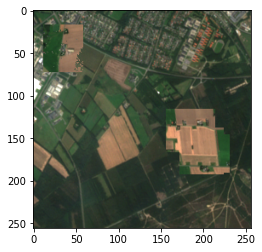

In [9]:
plt.imshow(unprocess(rgb_ab.detach()))

In [10]:
pixel_loss_fn = nn.MSELoss()

In [11]:
pixel_loss_fn(rgb_a_unchanged_area,rgb_a)

tensor(0.0076)

In [12]:
def style_loss_fn2(phi1, phi2):
    phi1 = relu3_3(phi1)
    phi2 = relu3_3(phi2)
    
    batch_size, c, h, w = phi1.shape
    psi1 = phi1.reshape((batch_size, c, w*h))
    psi2 = phi2.reshape((batch_size, c, w*h))
    
    gram1 = torch.matmul(psi1, torch.transpose(psi1, 1, 2)) / (c*h*w)
    gram2 = torch.matmul(psi2, torch.transpose(psi2, 1, 2)) / (c*h*w)
    # as described in johnson et al.
    print(gram1.shape)
    return torch.sum(torch.norm(gram1 - gram2, p = "fro", dim=(1,2))) / batch_size


In [13]:
style_loss_fn = StyleLoss(relu3_3)

In [14]:
style_loss_fn(rgb_a, rgb_a_unchanged_area)

tensor(0.1320, grad_fn=<DivBackward0>)

In [15]:
style_loss_fn2(rgb_a,rgb_a_unchanged_area)

torch.Size([1, 256, 256])


tensor(0.1320, grad_fn=<DivBackward0>)

In [16]:
lc_a.shape

torch.Size([1, 14, 256, 256])

In [17]:
d = Discriminator()
g = Generator()

In [18]:
d.load_state_dict(torch.load(f"results/run7/models/discriminator.pt"))
g.load_state_dict(torch.load(f"results/run7/models/generator.pt"))

<All keys matched successfully>

### Create IoU functions

In [19]:
def IoU(lc_a, lc_b, cla):
    union = lc_a[(lc_a == cla) | (lc_b == cla)].shape[0]
    if union == 0:
        return None
    return len(((lc_a == cla) | (lc_b == cla))[(lc_a == cla) & (lc_b == cla)]) / union

In [20]:
def calc_single_IoUs(lc_a, lc_b):
    """
    Calculates the mean IoU,
    the weights of each class depend on their total ratio in lc_a
    """
    c_ratio = []
    ious = []
    for c in range(14):
        iou = IoU(lc_a, lc_b, c)
        n = lc_a.shape[0] * lc_a.shape[1]
        if iou != None:
            ious.append(iou)
            c_ratio.append(lc_a[lc_a==c].shape[0] / n)
    return np.sum(np.array(ious) * np.array(c_ratio))

In [21]:
def calc_all_IoUs(lc_a, lc_b):
    lc_a = torch.argmax(lc_a, dim=1)
    lc_b = torch.argmax(lc_b, dim=1)
    return np.mean([calc_single_IoUs(lc_a[i], lc_b[i]) for i in range(lc_a.shape[0])])

In [22]:
gen_a = g(rgb_a, lc_a, binary_mask)

In [23]:
calc_all_IoUs(lc_a, gen_a)

0.011462806832508996

In [24]:
def plot_bar_iou():
    ious = []
    cs = []
    for c in range(14):
        iou = IoU(lc1, gen_a1, c)
        if iou:
            ious.append(iou)
            cs.append(c)
    plt.bar(cs, ious)

In [73]:
def c_to_i(cl):
    return create_img_from_classes(unprocess(cl.detach()))

### Test discriminator patchGAN

In [68]:
num_samples = 100
v_ds = SatelliteDataset("../../data/val", num_samples)
batch_size = 2
v_loader = DataLoader(v_ds, batch_size, shuffle=True)

In [76]:
adv_loss_fn = nn.MSELoss()
d_real_loss = 0
d_fake_loss = 0
d_fake_losses = []
loop = tqdm(v_loader)
for rgb_a, rgb_ab, lc_a, lc_b, binary_mask, lc_ab, masked_areas in loop:
    rgb_a, rgb_ab, lc_a, lc_b, binary_mask = rgb_a.to(device), rgb_ab.to(device), lc_a.to(device), lc_b.to(device), binary_mask.to(device)
    lc_ab = lc_ab.to(device)
    gen_lc_a, patchGAN_real = d(rgb_a)
    fake_img = g(rgb_a, lc_ab, binary_mask)
    gen_lc_fake_img, patchGAN_fake = d(fake_img)
    d_real_loss += adv_loss_fn(patchGAN_real, torch.ones_like(patchGAN_real)).item()
    c_fake_loss = adv_loss_fn(patchGAN_fake, torch.zeros_like(patchGAN_fake)).item()
    d_fake_loss += c_fake_loss
    d_fake_losses.append(c_fake_loss)
    if c_fake_loss < 0.18:
        plt.imshow(c_to_i(gen_lc_fake_img))

100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


In [89]:
print(f"d fake loss {d_fake_loss/(num_samples / batch_size)}")
print(f"d real loss, {d_real_loss/(num_samples / batch_size)}")

d fake loss 0.7580011367797852
d real loss, 0.06394879817962647


In [90]:
np.mean(d_fake_losses) 

0.7580011367797852

In [85]:
batch_size

2

In [87]:
d_fake_loss / (50*2)

0.3790005683898926

In [72]:
adv_loss_fn(patchGAN_fake, torch.zeros_like(patchGAN_fake)).item()

0.7300642728805542

In [28]:
fake_imgup = unprocess(fake_img.detach())

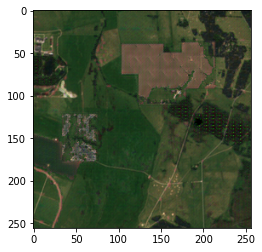

In [29]:
plt.imshow(fake_imgup)

In [30]:
rgb_aup = unprocess(rgb_a)

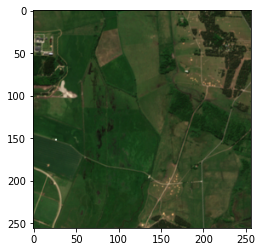

In [31]:
plt.imshow(rgb_aup)

In [32]:
a = torch.ones((2, 16, 16)) 

In [33]:
adv_loss_fn(a, torch.zeros_like(a))

tensor(1.)

In [34]:
tensor_type = torch.FloatTensor

### Test class loss

Not use cross entropy weights

In [35]:
cross_entropy_weights = torch.tensor([1.75827705e-05, 2.63985891e-02, 4.93802954e-01, 0.00000000e+00,
       9.56997597e-02, 6.52813402e-02, 2.43301976e-01, 2.19168076e-02,
       0.00000000e+00, 2.51651604e-02, 2.09771106e-02, 3.17152767e-03,
       0.00000000e+00, 4.26719143e-03]).to(device).type(tensor_type)

In [36]:
torch.sum(cross_entropy_weights)

tensor(1.)

In [37]:
class_loss_fn = nn.NLLLoss(1-cross_entropy_weights)
class_loss_fn = nn.NLLLoss()

In [38]:
lc_a1 = lc_a.type(tensor_type)

In [39]:
lc_a1m = torch.argmax(lc_a1,1)

In [40]:
lc_a1m.shape

torch.Size([2, 256, 256])

In [41]:
lc_a1.reshape(2, 14, 256*256)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [42]:
def cl(a, b):
    return 1 + class_loss_fn(a,b)

In [43]:
1+class_loss_fn(lc_a1, lc_a1m)

tensor(0.)

In [44]:
gen_lc_fake_img[0,:,0,0]

tensor([-0.9781, -0.5242,  2.4550, -0.9739, -0.0779, -0.2770,  2.8183, -0.6830,
        -0.9872, -0.6225, -0.7414, -0.9808, -0.9659, -0.9525],
       grad_fn=<SelectBackward>)

In [45]:
class_loss_fn(gen_lc_fake_img, torch.argmax(lc_ab,1))

tensor(-4.5979, grad_fn=<NllLoss2DBackward>)

In [46]:
1+class_loss_fn(lc_ab.type(torch.DoubleTensor), torch.argmax(lc_ab,1))

tensor(0., dtype=torch.float64)

In [47]:
def accuracy(pred, target):
    pred = torch.argmax(pred, dim=1)
    target = torch.argmax(target, dim=1)
    pred = pred.flatten()
    target = target.flatten() 
    return torch.tensor(target[target == pred].shape[0] / target.shape[0], requires_grad=True)

In [48]:
accuracy(lc_a, lc_b)

tensor(0.3379, requires_grad=True)

In [49]:
nn.L1Loss()(torch.argmax(lc_a,dim=1).type(torch.DoubleTensor),torch.argmax(lc_b,dim=1).type(torch.DoubleTensor))

tensor(2.6141, dtype=torch.float64)

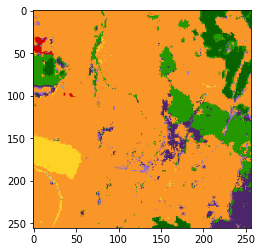

In [50]:
plt.imshow(create_img_from_classes(unprocess(lc_a.detach())))

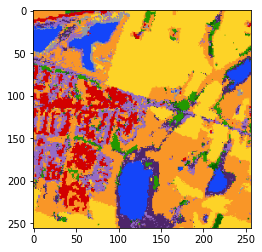

In [51]:
plt.imshow(create_img_from_classes(unprocess(lc_b.detach())))

In [52]:
nn.L1Loss()(torch.tensor([0.,1.]), torch.tensor([0.,1.]))

tensor(0.)

In [53]:
cl(lc_ab.type(torch.DoubleTensor), torch.argmax(lc_ab,1))

tensor(0., dtype=torch.float64)

In [54]:
nn.CrossEntropyLoss()(lc_ab.type(torch.DoubleTensor), torch.argmax(lc_ab,1))

tensor(1.7548, dtype=torch.float64)

In [55]:
lc_a1m.reshape(2,256*256)

tensor([[ 6,  6,  6,  ..., 10, 10, 10],
        [ 2,  2,  2,  ...,  4,  4,  4]])

In [56]:
inp = torch.zeros(4, 5)

In [57]:
inp[0,0]= 1
inp[1,1]=1
inp[2,2]=1
inp[3,3] = 1

In [58]:
inp = torch.zeros(1,5)
inp[0,0] = 1

In [59]:
inp

tensor([[1., 0., 0., 0., 0.]])

In [60]:
target = torch.tensor([2])

In [61]:
loss = nn.NLLLoss()
loss(inp, target)

tensor(0.)

In [62]:
target

tensor([2])

In [63]:
pred1 = torch.tensor([[0.7,0.2,0.1]])
pred2 = torch.tensor([[0.1,0.8,0.1]])
pred3 = torch.tensor([[1.,0.,0.]])
pred4 = torch.tensor([[0.,1.,0.]])
y = torch.tensor([1])

In [64]:
loss = nn.NLLLoss()
loss(pred1, y)

tensor(-0.2000)

In [65]:
loss(pred2,y)

tensor(-0.8000)

In [66]:
loss(pred3, y)

tensor(0.)

In [67]:
-loss(pred4, y)

tensor(1.)